# Example on how Bloom / Hash Embedding works

This embedding uses single features of its inputs to create an embedding.
Each feature can be represented by an vector with M elements. The sum of all
features generates the input vector.

In [1]:
%matplotlib inline  

import numpy as np
import mmh3
import random
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

As you can see, with need embeddings for 20 words:

In [2]:
nouns = ['bunch', 'audience', 'flock', 'team', 'group', 'family', 
         'band', 'village', 'cat', 'sock', 'ship', 'hero',
         'monkey', 'baby', 'match', 'bed', 'dog', 'bottle', 'house',
         'paper']

len(nouns)

20

Let's say we choose 10 feature vectors, each with 2 elements, that can represent
a single word:

In [3]:
num_features = 10
feature_size = 2
feature_vecs = np.random.uniform(-0.1, 0.1, (num_features, feature_size))

print(feature_vecs)

[[-0.02509198  0.09014286]
 [ 0.04639879  0.0197317 ]
 [-0.06879627 -0.0688011 ]
 [-0.08838328  0.07323523]
 [ 0.020223    0.04161452]
 [-0.0958831   0.09398197]
 [ 0.06648853 -0.05753218]
 [-0.06363501 -0.0633191 ]
 [-0.03915155  0.00495129]
 [-0.013611   -0.04175417]]


Now we need to define a rule, that maps **one** input onto **M** of these vectors.
Normally we would check for specific word features (POS, position in text, ...).
In this example we use Hashes to map words onto a range from `0` to `num_features - 1`:

In [4]:
feature_keys_a = [mmh3.hash(n, 1) % num_features for n in nouns]
feature_keys_b = [mmh3.hash(n, 2) % num_features for n in nouns]
feature_keys_c = [mmh3.hash(n, 3) % num_features for n in nouns]

print(f'Inividual features for a: {len(set(feature_keys_a))}')
print(f'Inividual features for b: {len(set(feature_keys_b))}')
print(f'Inividual features for c: {len(set(feature_keys_c))}')

Inividual features for a: 7
Inividual features for b: 9
Inividual features for c: 10


As you can see, one feature alone can't differentiate between every single word.
There are collisions! Because of this we combine our features. This way, each word is defined
by three features:

In [5]:
feature_keys = list(zip(
    feature_keys_a,
    feature_keys_b,
    feature_keys_c,
))

print(f'Feature keys for first two inputs: {feature_keys[:2]}')
print(f'Individual combined features: {len(set(feature_keys))}')

Feature keys for first two inputs: [(3, 7, 1), (6, 0, 3)]
Individual combined features: 20


Now we can see, every word is represented by an individual tuple of keys.
In the last step we can search for the corresponding features and add them up:

In [6]:
embeddings = []
for keys in feature_keys:
    emb = sum(feature_vecs[k] for k in keys)
    embeddings.append(emb)

In [7]:
for word, emb in zip(nouns, embeddings):
    print(f'{word} -> {emb}')

bunch -> [-0.1056195   0.02964783]
audience -> [-0.04698673  0.10584591]
flock -> [-0.09819084 -0.0323513 ]
team -> [-0.15236199 -0.03649533]
group -> [-0.24790139  0.1038981 ]
family -> [-0.16642156 -0.12168691]
band -> [0.01700422 0.05618149]
village -> [-0.03629803 -0.11589999]
cat -> [0.02747024 0.0662975 ]
sock -> [-0.07366525  0.06295628]
ship -> [-0.07110402 -0.19513437]
hero -> [-0.2053772   0.14620977]
monkey -> [0.02450404 0.03543475]
baby -> [-0.13786759  0.1869489 ]
match -> [-0.09302958 -0.02686931]
bed -> [-0.11381896  0.11696662]
dog -> [ 0.15320006 -0.07344984]
bottle -> [-0.19606629 -0.19543929]
house -> [-0.24556283  0.07766936]
paper -> [ 0.07310053 -0.05767183]


Now each word has it's own representation, even though we only store 10 feature vectors!
However, this example has one flaw: Adding an unknown word may be possible, but it is dependent 
on a random hash function. So even if we train a model on these words, results for new
won't make any sense.

For example: We use this method to check if a word is a noun or verb. We may be able to train a model,
but for new words arbitrary hash values will be generated to get feature vectors. So it is not possible
to say if an unknown word is a verb or noun.

But what we can test is training a model on the known words

In [8]:
nb_epoch = 100
learn_rate = 0.01
    
labels = np.random.uniform(-0.1, 0.1, (len(nouns), 2))
train_data = list(zip(nouns, feature_keys, labels))

losses = []

for epoch in range(nb_epoch):
    random.shuffle(train_data)
    loss=0.0

    for noun, keys, y in train_data:
        hash_vector = sum(feature_vecs[key] for key in keys)

        error = hash_vector - y

        for key in keys:
            feature_vecs[key] -= learn_rate * error

        loss += (error**2).sum()
    losses.append(loss)
    

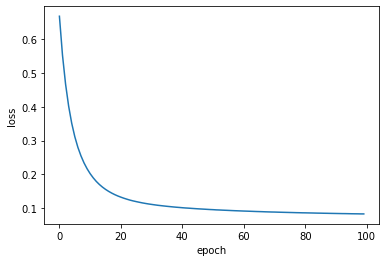

In [9]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
